# Advanced Lane Finding

In this Jupyter notebook we are going to implement the different steps to detect the road lanes with the techniques learnt in the lessons of the Udacity web

### Camera Calibration

In this first cell we are going to read all the calibration files, caclulate the chessboard corners and link them to the 2D coordiantes of the grid

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In the next cell we calibrate the camera with the points obtained in the last cell and undistort one of the sample images 

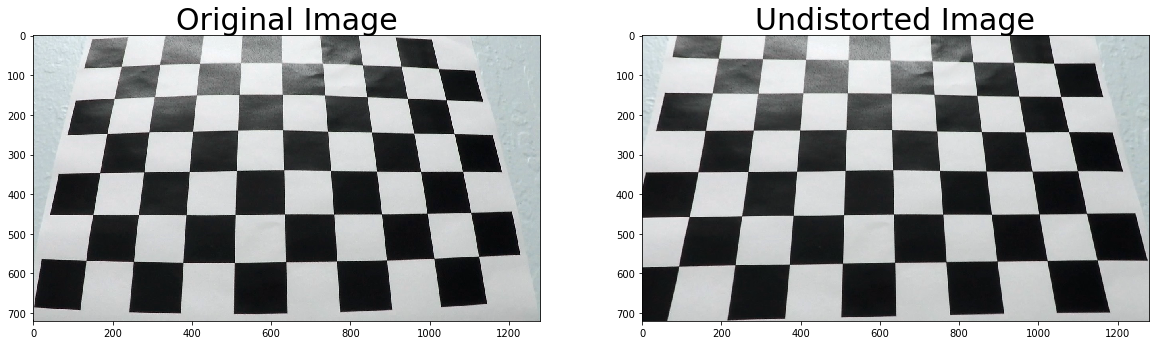

In [4]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/calibration3_un.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Now we are going to undistort the sample images of the road

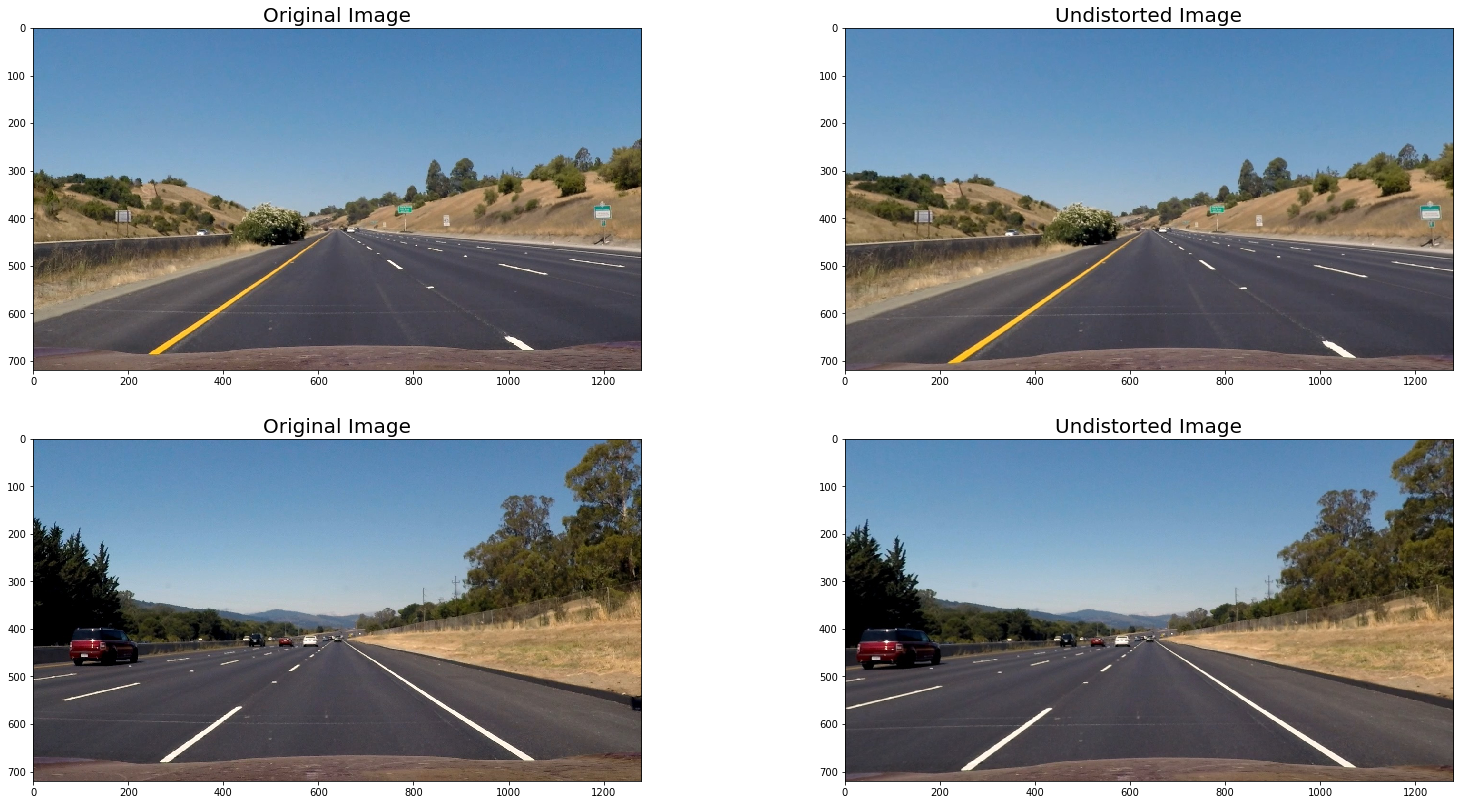

In [22]:
images = glob.glob('test_images/straight*.jpg')
dist_pickle = pickle.load(open("wide_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
f, axarr = plt.subplots(len(images), 2, figsize=(50,20))
cont=0
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #plt.imshow(img)
    axarr[cont,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axarr[cont,0].set_title('Original Image', fontsize=20)
    axarr[cont,1].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    axarr[cont,1].set_title('Undistorted Image', fontsize=20)
    cont+=1

Now we are going to detect the edges from the road

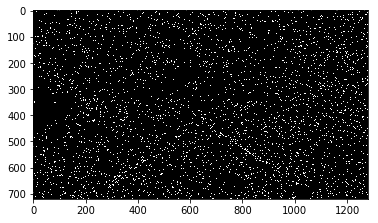

In [64]:
# The img must be in the BGR color space
def abs_sobel_thresh(img, orient='x', thresh_min=30, thresh_max=100):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if (orient == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary
def mag_thresh(img, sobel_kernel=3, thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output
def dir_thresh(image, sobel_kernel=3, thresh=(0.9, 1.0)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output
plt.imshow(dir_thresh(cv2.imread('test_images/straight_lines1.jpg')),cmap='gray')